In [110]:
"""
Authors      : Aditya Jain and Safwan Jamal
Date started : November 8, 2022
About        : Convex Optimization project; code for solving convex opt problem
"""

import os
import glob
import numpy as np
import pickle
import cvxpy as cp
import seaborn as sns

#### Reading dissimilarity data data

In [111]:
filename = open('./dissimilarity_data/automobile_dissimilarity_matrix_4x4.pickle', 'rb')
D        = pickle.load(filename)
n        = len(D)

#### Optimization program

In [112]:
# variable definitions
Z        = cp.Variable((n, n), symmetric=True)
lambda_t = 6.55


# objective function
cost_encoding = cp.trace(D.T@Z)        # cost of encoding all data points using representatives
cost_no_repr  = 0                      # cost associated with no. of representatives
for i in range(n):
    cost_no_repr += cp.norm2(Z[i, :])
cost_no_repr = lambda_t*cost_no_repr
objective    = cp.Minimize(cost_encoding + cost_no_repr)

# constraints
# probab. should be >=0
# probabilities should sum to one for every column
constraints = [Z>=0, np.ones((1,n))@Z == np.ones((1,n))]

# optimization program
prob = cp.Problem(objective, constraints)
prob.solve()

15.842844417505518

<AxesSubplot: >

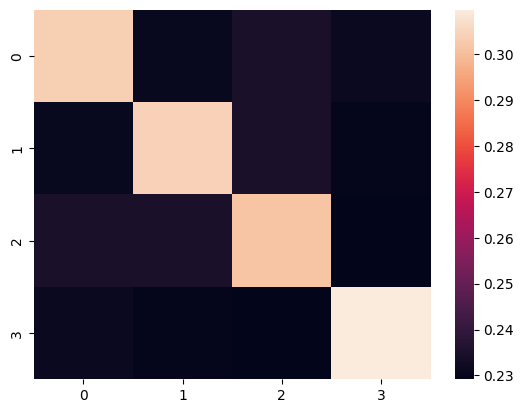

In [113]:
sns.heatmap(Z.value)

In [114]:
Z.value

array([[0.30350322, 0.23080932, 0.23463273, 0.23105473],
       [0.23080932, 0.30437878, 0.23475462, 0.23005727],
       [0.23463273, 0.23475462, 0.30146068, 0.22915196],
       [0.23105473, 0.23005727, 0.22915196, 0.30973603]])